# Introduction to Distributed Training with PyTorch and Ray Train

This notebook will walk you through the basics of distributed training with Ray Train and PyTorch.

<div class="alert alert-block alert-info">

<b> Here is the roadmap for this notebook </b>

<ol>
  <li>When to use Ray Train</li>
  <li>Single GPU Training with PyTorch</li>
  <li>Distributed Data Parallel Training with Ray Train and PyTorch</li>
  <li>Integrating Ray Train with Ray Data</li>
  <li>Fault tolerance in Ray Train</li>
  <li>Ray Train in Production</li>
</ol>
</div>

**Imports**

In [3]:
import csv
import datetime
import os   
import tempfile

from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose

import ray
from ray.train import ScalingConfig, RunConfig
from ray.train.torch import TorchTrainer

## 1. When to use Ray Train

Use Ray Train when you face one of the following challenges:

|Challenge|Detail|Solution|
|---|---|---|
|Need to speed up or scale up training| Training jobs might take a long time to complete, or require a lot of compute | Ray Train provides a distributed training framework that allows engineers to scale training jobs to multiple GPUs |
|Minimize overhead of setting up distributed training| Engineers need to manage the underlying infrastructure | Ray Train handles the underlying infrastructure via Ray's autoscaling |
|Achieve observability| Engineers need to connect to different nodes and GPUs to find the root cause of failures, fetch logs, traces, etc | Ray Train provides observability via Ray's dashboard, metrics, and traces that allow engineers to monitor the training job |
|Ensure reliable training| Training jobs can fail due to hardware failures, network issues, or other unexpected events | Ray Train provides fault tolerance via checkpointing, automatic retries, and the ability to resume training from the last checkpoint |
|Avoid significant code rewrite| Engineers might need to fully rewrite their training loop to support distributed training | Ray Train provides a suite of integrations with the PyTorch ecosystem, Tree-based methods (XGB, LGBM), and more to minimize the amount of code changes needed |


## 2. Single GPU Training with PyTorch

### 2.1. Overview

We will start by fitting a `ResNet18` model to an `MNIST` dataset. Conceptually we will follow the below recipe presented below.

|<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/single_gpu_pytorch_v3.png" width="70%" loading="lazy">|
|:--|
|An overview of the single GPU training process. At a high level, here is how training loop in PyTorch looks like. The key stages include loading the dataset; run the training on mini-batches on a single GPU; saving the model checkpoint to the persistent storage.|

In [4]:
def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, local_path: str = "./checkpoints"):

    # Model, Loss, Optimizer
    criterion = CrossEntropyLoss()
    model = load_model_torch()
    optimizer = Adam(model.parameters(), lr=1e-5)

    # Load the data loader
    data_loader = build_data_loader_torch(batch_size=batch_size)

    # Training loop
    for epoch in range(num_epochs):
        for images, labels in data_loader:

            # Move the data to the GPU
            images, labels = images.to("cuda"), labels.to("cuda")

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

        # Report the metrics
        metrics = report_metrics_torch(loss=loss, epoch=epoch)
        
        # Save the checkpoint and metrics
        Path(local_path).mkdir(parents=True, exist_ok=True)
        save_checkpoint_and_metrics_torch(metrics=metrics, model=model, local_path=local_path)

<div class="alert alert-block alert-info">

Quick notes:

<ul>
    <li><code>report_metrics_torch</code> and <code>save_checkpoint_and_metrics_torch</code> are defined below,</li>
    <li><code>local_path</code> is used for checkpointing. (default) Current working directory simply points to the notebook location (check <code>pwd</code> below).</li>
</ul>
</div>

In [5]:
!pwd

/home/ray/default_cld_g54aiirwj1s8t9ktgzikqur41k/vhol-ray-train/02-ddp-pytorch-ray


### 2.2. Build model and load it on the GPU

Build [Resnet18](https://pytorch.org/vision/main/models/resnet.html#resnet)

In [6]:
def build_resnet18():
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        in_channels=1, # grayscale MNIST images
        out_channels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False,
    )
    return model

<div class="alert alert-block alert-info">

resnet18's <code>model.conv1</code> has <code>in_channels=3</code> by default. Here, we work with the <a href="https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#mnist" target="_blank">MNIST</a> grayscale images, thus <code>in_channels=1</code>.
</div>

Load the model on a single GPU

In [7]:
def load_model_torch() -> torch.nn.Module:
    model = build_resnet18()

    # move to the GPU device
    model.to("cuda")
    return model

### 2.3. Create Dataset and DataLoader

In [8]:
dataset = MNIST(root="./data", train=True, download=True)

In [12]:
!ls ./data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Let's display 9 example (image, target) pairs:

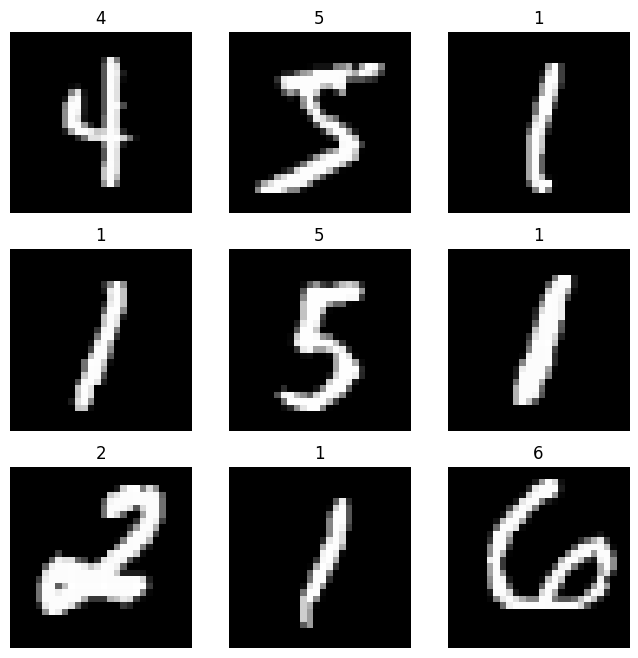

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")

Define a DataLoader to apply transformations and load data in batches

In [14]:
def build_data_loader_torch(batch_size: int) -> torch.utils.data.DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

### 2.4. Create metrics and checkpoiting

Compute and report the metrics using a simple print statement, and also save them to a CSV file.

In [15]:
def report_metrics_torch(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch}
    print(metrics)
    return metrics

Save the checkpoint in a previously defined local directory.

In [16]:
def save_checkpoint_and_metrics_torch(metrics: dict[str, float], model: torch.nn.Module, local_path: str) -> None:

    # Save the metrics
    with open(os.path.join(local_path, "metrics.csv"), "a") as f:
        writer = csv.writer(f)
        writer.writerow(metrics.values())

    # Save the model
    checkpoint_path = os.path.join(local_path, "model.pt")
    torch.save(model.state_dict(), checkpoint_path)

### 2.5. Run the training loop
Schedule the training loop on a single GPU

In [17]:
timestamp = datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H-%M-%S")
local_path = f"/mnt/local_storage/single_gpu_mnist/torch_{timestamp}/"

<div class="alert alert-info">

<b>Note about Anyscale storage options</b>

In this example <code>local_path</code> points to the Anyscale's <a href="https://docs.anyscale.com/configuration/storage/#local-storage-for-a-node" target="_blank">local storage</a>. It's a convenient and quick access location for this basic example.

* Anyscale provides each node with its own volume and disk and doesn’t share them with other nodes.
* Local storage is very fast - Anyscale supports the Non-Volatile Memory Express (NVMe) interface.
* This is not a persisent storage, Anyscale deletes data in the local storage after instances are terminated. 

Read more about available <a href="https://docs.anyscale.com/configuration/storage" target="_blank">storage</a> options.
</div>

Start the training:

In [18]:
train_loop_torch(
    num_epochs=3,
    local_path=local_path
)

{'loss': 0.23444394767284393, 'epoch': 0}
{'loss': 0.19371330738067627, 'epoch': 1}
{'loss': 0.14566871523857117, 'epoch': 2}


Let's inspect the produced checkpoints and metrics

In [19]:
!ls -l {local_path}

total 43736
-rw-r--r-- 1 ray users       69 Jan 26 23:20 metrics.csv
-rw-r--r-- 1 ray users 44773963 Jan 26 23:20 model.pt


In [20]:
metrics = pd.read_csv(
    os.path.join(local_path, "metrics.csv"),
    header=None,
    names=["loss", "epoch"],
)

metrics

,loss,epoch
0,0.234444,0
1,0.193713,1
2,0.145669,2


### 2.6. Use checkpointed model to generate predictions

Load model checkpoint to GPU

In [21]:
loaded_model = build_resnet18()
loaded_model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))
loaded_model.to("cuda")
loaded_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Generate predictions on randomly selected 9 images rom the MNIST dataset.

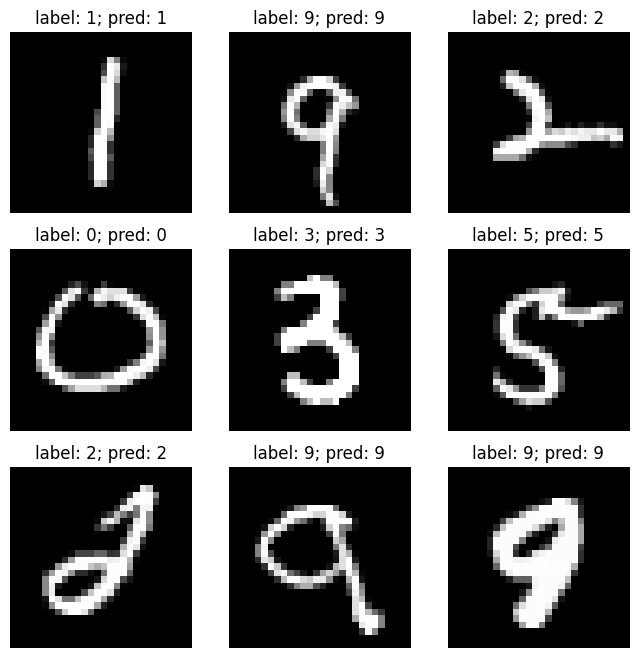

In [22]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]
    normalized_img = Normalize((0.5,), (0.5,))(ToTensor()(img))
    normalized_img = normalized_img.to("cuda")

    # use loaded model to generate preds
    with torch.no_grad():        
        prediction = loaded_model(normalized_img.unsqueeze(0)).argmax().cpu()

    figure.add_subplot(rows, cols, i)
    plt.title(f"label: {label}; pred: {int(prediction)}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")

## 3. Distributed Data Parallel Training with Ray Train and PyTorch

## Architecture overview

Ray Train's architecture is based on the following components:
1. A Ray Train Controller/Driver that schedules the training workers, handles errors and manages checkpoints
2. Ray Train Worker executing the training code


Key API concepts

Below are the key API concepts of Ray Train:

1. `train_loop_per_worker`: This is the main function that contains your model training logic.
2. `ScalingConfig`: This is used to specify the number of workers and compute resources (CPUs or GPUs, TPUs).
3. `Trainer`: This is used to manage the training process.
4. `Trainer.fit()`: This is used to start the training process.

<img src="https://docs.ray.io/en/latest/_images/overview.png" width="700" loading="lazy">

Below is the diagram showing how the key components usually work together.

- The Train Controller/Driver is constantly performing health checks on the Train workers.
- The Train workers are running the training loop and at a particular frequency checkpointing the model to a persistent storage.

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/ray-train-deep-dive/ray_train_detailed_architecture.png" width="800" loading="lazy">


Let's consider the case where we have a very large dataset of images that would take a long time to train on a single GPU. We would now like to scale this training job to run on multiple GPUs.

|<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_v4.png" width="70%" loading="lazy">|
|:--|
|Schematic overview of DistributedDataParallel (DDP) training: (1) the model is replicated from the <code>GPU rank 0</code> to all other workers; (2) each worker receives a shard of the dataset and processes a mini-batch; (3) during the backward pass, gradients are averaged across GPUs; (4) checkpoint and metrics from rank 0 GPU are saved to the persistent storage.|

<div class="alert alert-block alert-info">
<b>Here is a migration roadmap: from PyTorch DDP to PyTorch with Ray Train</b>

<ol>
    <li>Configure scale and GPUs</li>
    <li>Migrate the model to Ray Train</li>
    <li>Migrate the dataset to Ray Train</li>
    <li>Build checkpoints and metrics reporting</li>
    <li>Configure persistent storage</li>
</ol>
</div>

### 3.1. Overview of the training loop in Ray Train

Let's see how this data-parallel training loop will look like with Ray Train and PyTorch.

In [23]:
def train_loop_ray_train(config: dict):  # pass in hyperparameters in config

    criterion = CrossEntropyLoss()

    # Use Ray Train to wrap the model with DistributedDataParallel
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-5)

    # Calculate the batch size for each worker
    global_batch_size = config["global_batch_size"]
    world_size = ray.train.get_context().get_world_size()
    batch_size = global_batch_size // world_size
    print(f"{world_size=}\n{batch_size=}")

    # Use Ray Train to wrap the data loader as a DistributedSampler
    data_loader = build_data_loader_ray_train(batch_size=batch_size)

    # Main training loop
    for epoch in range(config["num_epochs"]):

        # Ensure data is on the correct device
        data_loader.sampler.set_epoch(epoch)

        # images, labels are now sharded across the workers
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()

            # gradients are now accumulated across the workers
            loss.backward()
            optimizer.step()

        # Use Ray Train to report metrics
        metrics = print_metrics_ray_train(loss, epoch)

        # Use Ray Train to save checkpoint and metrics
        save_checkpoint_and_metrics_ray_train(model, metrics)

<div class="alert alert-block alert-info">

<b>Main training loop</b>
<ul>
  <li><strong>global_batch_size</strong>: the total number of samples processed in a single training step of the entire training job.
    <ul>
      <li>It's estimated like this: <code>batch size * DDP workers * gradient accumulation steps</code>.</li>
    </ul>
  </li>
  <li>Notice that images and labels are no longer manually moved to device (<code>images.to("cuda")</code>). This is done by 
    <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader" target="_blank">
      prepare_data_loader()
    </a>.
  </li>
  <li>Config that will be passed here, is defined below. It will be passed to the Ray Train's <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.TorchTrainer.html#ray-train-torch-torchtrainer" target="_blank">TorchTrainer</a>.</li>
  <li>
    <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.v2.api.context.TrainContext.html#ray-train-v2-api-context-traincontext" target="_blank">
      TrainContext
    </a> lets users get useful information about the training i.e. node rank, world size, world rank, experiment name.
  </li>

  <li><code>load_model_ray_train</code> and <code>build_data_loader_ray_train</code> are implemented below.</li>
</ul>
</div>

In [24]:
train_loop_config = {
    "num_epochs": 2, 
    "global_batch_size": 128
}

### 3.2. Configure scale and GPUs
Outside of our training function, we create a `ScalingConfig`.

In [25]:
scaling_config = ScalingConfig(num_workers=2, use_gpu=True)

<div class="alert alert-block alert-info">

<a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.ScalingConfig.html#ray-train-scalingconfig" target="_blank">ScalingConfig</a> configures:

<ul>
  <li><code>num_workers</code>: The number of distributed training worker processes.</li>
  <li><code>use_gpu</code>: Whether each worker should use a GPU (or CPU).</li>
</ul>

See docs on configuring <a href="https://docs.ray.io/en/latest/train/user-guides/using-gpus.html" target="_blank">scale and GPUs</a> for more details.
</div>

#### 2.3.1. Note on Ray Train key concepts

Ray Train is built around [four key concepts](https://docs.ray.io/en/latest/train/overview.html):
1. **Training function**: (implemented above `train_loop_ray_train`): A Python function that contains your model training logic.
1. **Worker**: A process that runs the training function.
1. **Scaling config**: specifices number of workers and compute resources (CPUs or GPUs, TPUs).
1. **Trainer**: A Python class (Ray Actor) that ties together the training function, workers, and scaling configuration to execute a distributed training job.

|<img src="https://docs.ray.io/en/latest/_images/overview.png" width="60%" loading="lazy">|
|:--|
|High-level architecture of how Ray Train|

### 3.3. Migrating the model to Ray Train

Use the [`prepare_model()`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model) utility function to:

* automatically move your model to the correct device,
* wrap the model in PyTorch's DDP or FSDP.

In [ ]:
def load_model_ray_train() -> torch.nn.Module:
    model = build_resnet18()
    model = ray.train.torch.prepare_model(model) # Instead of model = model.to("cuda")
    return model

<div class="alert alert-block alert-info">
  <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model" target="_blank">
    prepare_model()
  </a> allows users to specify additional parameters:
  <ul>
    <li><code>parallel_strategy</code>: "ddp", "fsdp" – wrap models in <code>DistributedDataParallel</code> or <code>FullyShardedDataParallel</code></li>
    <li><code>parallel_strategy_kwargs</code>: pass additional arguments to "ddp" or "fsdp"</li>
  </ul>
  <p>
    With <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model" target="_blank">
      prepare_model()
    </a> you can use the same code regardless of number of workers or the device type being used (CPU, GPU).
  </p>
</div>

### 3.4. Migrating the dataset to Ray Train

Use the [`prepare_data_loader()`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader) utility function, to automatically:

* move the batches to the right device,
* copy data from host (CPU) memory to device (GPU) memory,
* pass PyTorch's [`DistributedSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler) to the DataLoader, if using more than 1 worker. Each worker will load a subset of the original dataset that is exclusive to it.

[`prepare_data_loader()`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader) allows users to use the same code regardless of number of workers or the device type being used (CPU, GPU).

In [27]:
def build_data_loader_ray_train(batch_size: int) -> torch.utils.data.DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    # Automatically pass a DistributedSampler instance as a DataLoader sampler
    train_loader = ray.train.torch.prepare_data_loader(train_loader)
    return train_loader

<div class="alert alert-block alert-warning">

<b>Ray Data integration</b>

This step isn't necessary if you are integrating your Ray Train workload with Ray Data. It's especially useful if preprocessing is CPU-heavly and user wants to run preprocessing and training of separate instances.
</div>

### 3.5. Reporting checkpoints and metrics

To monitor progress, we can continue to print/log metrics as before. This time we chose to log from all workers.

In [28]:
def print_metrics_ray_train(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch}
    world_rank = ray.train.get_context().get_world_rank() # report from all workers
    print(f"{metrics=} {world_rank=}")
    return metrics

<div class="alert alert-block alert-info">

If you want to log only from the rank 0 worker, use this code:

```python
def print_metrics_ray_train(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch}
    if ray.train.get_context().get_world_rank() == 0:  # report only from the rank 0 worker
        print(f"{metrics=} {world_rank=}")
    return metrics
```

</div>

We will report intermediate metrics and checkpoints using the [`ray.train.report`](https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray.train.report) utility function.

In [29]:
def save_checkpoint_and_metrics_ray_train(
    model: torch.nn.Module, metrics: dict[str, float]
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        torch.save(
            model.module.state_dict(),  # note the `.module` to unwrap the DistributedDataParallel
            os.path.join(temp_checkpoint_dir, "model.pt"),
        )

        ray.train.report(
            metrics,
            checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
        )

<div class="alert alert-block alert-info">
  <p><strong>Quick notes:</strong></p>
  <ul>
    <li>
      Use 
      <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray.train.report" target="_blank">
        ray.train.report
      </a> to save the metrics and checkpoint.
    </li>
    <li>Only metrics from the rank 0 worker are reported.</li>
  </ul>
</div>

#### 2.6.1. Note on the checkpoint lifecycle

Here is the lifecycle of a checkpoint from being created using a local path to being uploaded to persistent storage.

<img src="https://docs.ray.io/en/latest/_images/checkpoint_lifecycle.png" width=800>


<div class="alert alert-block alert-info">
  <p><strong>Notes:</strong></p>
  <ul>
    <li>
      Given it is the same model across all workers, we can instead only build the checkpoint on the worker of rank 0.
      Note that we will still need to call 
      <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray.train.report" target="_blank">
        ray.train.report
      </a> on all workers to ensure that the training loop is synchronized.
    </li>
    <li>Ray Train expects all workers to be able to write files to the same persistent storage location.</li>
    <li>Cloud storage is the recommended persistent storage location.</li>
  </ul>
</div>

In [30]:
def save_checkpoint_and_metrics_ray_train(
    model: torch.nn.Module, metrics: dict[str, float]
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None

        # checkpoint only from rank 0 worker
        if ray.train.get_context().get_world_rank() == 0:
            torch.save(
                model.module.state_dict(), os.path.join(temp_checkpoint_dir, "model.pt")
            )
            checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)

        ray.train.report(
            metrics,
            checkpoint=checkpoint,
        )

Check our guide on [saving and loading checkpoints](https://docs.ray.io/en/latest/train/user-guides/checkpoints.html) for more details and best practices.

### 3.6. Configure remote storage

Create a `RunConfig` object to specify the path where results (including checkpoints and artifacts) will be saved.

In [31]:
storage_path = "/mnt/cluster_storage/training/"
run_config = RunConfig(storage_path=storage_path, name="distributed-mnist-resnet18")

### 3.7. Launching the distributed training job

Distributed data-parallel training, but now using Ray Train.

|<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_annotated_v5.png" width="70%" loading="lazy">|
|:--|
||

We can now launch a distributed training job with a [`TorchTrainer`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.TorchTrainer.html#ray.train.torch.TorchTrainer).

In [32]:
trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config=train_loop_config,
)

Calling `trainer.fit()` will start the run and block until it completes.

We'll be able to observe relevant logs

In [ ]:
result = trainer.fit()

2026-01-26 23:24:34,611	INFO worker.py:1832 -- Connecting to existing Ray cluster at address: 10.0.60.67:6379...
2026-01-26 23:24:34,622	INFO worker.py:2003 -- Connected to Ray cluster. View the dashboard at https://session-g6iqlxs5pyemfy8rf3nywleh83.i.anyscaleuserdata.com 
2026-01-26 23:24:34,782	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_ec331c179880b128fd10f91882efe32aca08b69b.zip' (63.53MiB) to Ray cluster...
2026-01-26 23:24:35,059	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_ec331c179880b128fd10f91882efe32aca08b69b.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(TrainController pid=129185) [State Transition] INITIALIZING -> SCHEDULIN

(autoscaler +9m38s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


### 3.8. Access the training results

After training completes, a `Result` object is returned which contains information about the training run, including the metrics and checkpoints reported during training.

In [34]:
result

Result(metrics={'loss': 0.14724265038967133, 'epoch': 1}, checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/checkpoint_2026-01-26_23-26-45.051078), error=None, path='/mnt/cluster_storage/training/distributed-mnist-resnet18', metrics_dataframe=       loss  epoch
0  0.303487      0
1  0.147243      1, best_checkpoints=[(Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/checkpoint_2026-01-26_23-26-31.570128), {'loss': 0.30348682403564453, 'epoch': 0}), (Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/checkpoint_2026-01-26_23-26-45.051078), {'loss': 0.14724265038967133, 'epoch': 1})], _storage_filesystem=<pyarrow._fs.LocalFileSystem object at 0x7ff7443b8c30>)

We can check the metrics produced by the training job.

In [39]:
result.metrics_dataframe

,loss,epoch
0,0.303487,0
1,0.147243,1


### 3.9. Use checkpointed model to generate predictions

We can also take the latest checkpoint and load it to inspect the model.

In [40]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model_ray_train = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model_ray_train.load_state_dict(state_dict)
    loaded_model_ray_train.to("cuda")
    loaded_model_ray_train.eval()

loaded_model_ray_train

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<div class="alert alert-block alert-info">
  <p>
    To learn more about the training results, see this 
    <a href="https://docs.ray.io/en/latest/train/user-guides/results.html" target="_blank">
      docs
    </a> on inspecting the training results.
  </p>
</div>

Generate predictions on randomly selected 9 images rom the MNIST dataset.

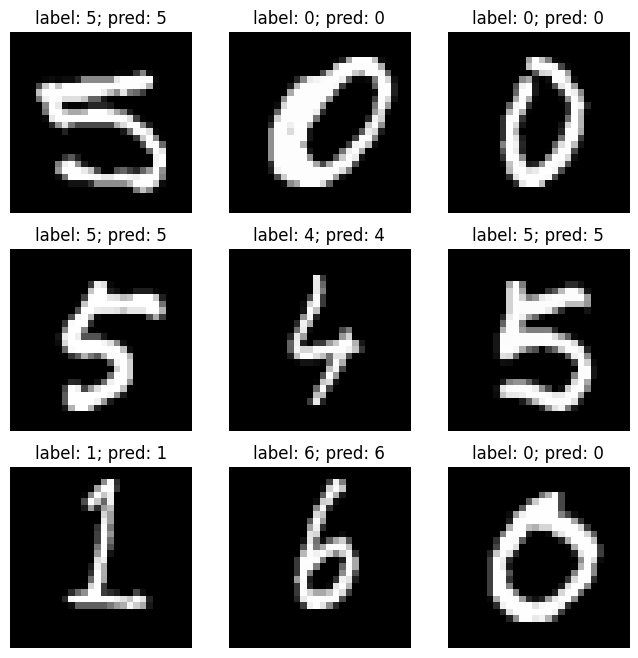

In [41]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]
    normalized_img = Normalize((0.5,), (0.5,))(ToTensor()(img))
    normalized_img = normalized_img.to("cuda")

    # use loaded model to generate preds
    with torch.no_grad():        
        prediction = loaded_model_ray_train(normalized_img.unsqueeze(0)).argmax().cpu()

    figure.add_subplot(rows, cols, i)
    plt.title(f"label: {label}; pred: {int(prediction)}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")

### 3.10. Activity: Run the distributed training with more workers

<div class="alert alert-block alert-info">

1. Update the scaling configuration to make use of 4 GPU workers
2. Run the trainer using the same hypeparameters

Use the following code snippets to guide you:

```python
# Hint: Update the scaling configuration
scaling_config = ...

trainer = ray.train.torch.TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
result.metrics_dataframe
```

</div>

In [35]:
# Write your solution here


<div class="alert alert-block alert-info">

<details>

<summary> Click here to see the solution </summary>

```python
scaling_config = ScalingConfig(num_workers=4, use_gpu=True)

trainer = ray.train.torch.TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
result.metrics_dataframe
```

</details>

## 3. Integrating Ray Train with Ray Data

### 3.1 When to integrate Ray Train with Ray Data
Use both Ray Train and Ray Data when you face one of the following challenges:
| Challenge | Detail | Solution |
| --- | --- | --- |
| Need to perform online or just-in-time data processing | The training pipeline requires processing data on the fly, such as data augmentation, normalization, or other transformations that may differ for each training epoch. | Ray Train's integration with Ray Data makes it easy to implement just-in-time data processing. |
| Need to improve hardware utilization | Training and data processing need to be scaled independently to keep GPUs fully utilized, especially when preprocessing is CPU-intensive. | Ray Data can distribute data processing across multiple CPU nodes, while Ray Train runs the training loop on GPUs. |
| Need a consistent interface for loading data | The training process may need to load data from various sources, such as Parquet, CSV, or lakehouses. | Ray Data provides a consistent interface for loading, shuffling, sharding, and batching data for training loops. |

Here is a diagram showing the Ray Data and Ray Train integration

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/ray-train-deep-dive/ray_train_v2_architecture.png" width="1200" loading="lazy">

### 3.2. Integrating Ray Train with Ray Data

Here is how our training loop will look like using **Ray Data** instead of the **PyTorch DataLoader**:

In [42]:
def train_loop_ray_train_ray_data(config: dict):
    # Same initialization as before
    criterion = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # This time we use Ray Train's integration with Ray Data to load the data
    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train_ray_data(batch_size=batch_size) 
    

    for epoch in range(config["num_epochs"]):
        # No longer need to ensure data is on the correct device
        # data_loader.sampler.set_epoch(epoch)

        # Note our batches are now dictionaries instead of tuples
        for batch in data_loader: 
            outputs = model(batch["image"])
            loss = criterion(outputs, batch["label"])
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()


        metrics = print_metrics_ray_train(loss, epoch)
        save_checkpoint_and_metrics_ray_train(model, metrics)


Here is the updated `build_data_loader_ray_train_ray_data` function that uses Ray Data to load the data:

In [43]:
def build_data_loader_ray_train_ray_data(
    batch_size: int, prefetch_batches: int = 2
):
    dataset_iterator = ray.train.get_dataset_shard("train")
    data_loader = dataset_iterator.iter_torch_batches(
        batch_size=batch_size, prefetch_batches=prefetch_batches
    )
    return data_loader

<div class="alert alert-block alert-info">

**Note** Use the `iter_torch_batches` function to build a torch compatible data loader.

</div>

### 3.3. Preparing the data
Let's store the training data in a format that Ray Data can easily read. 

Let's use the Parquet format, which is a columnar storage format that is efficient for reading and writing data.

In [44]:
df = pd.DataFrame({"image": dataset.data.tolist(), "label": dataset.targets})
df.to_parquet("/mnt/cluster_storage/cifar10.parquet")

Next, construct a Ray Data Dataset from the Parquet source.

In [45]:
train_ds = ray.data.read_parquet("/mnt/cluster_storage/cifar10.parquet")

Perform the same preprocessing steps that pytorch data loader does.

In [46]:
def transform_images(row: dict):
    # Define the torchvision transform.
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    image_arr = np.array(row["image"], dtype=np.uint8)
    row["image"] = transform(Image.fromarray(image_arr))
    return row

<div class="alert alert-block alert-info">

**Note** Unlike the PyTorch DataLoader, the preprocessing can now occur on any node in the cluster.

The data will be passed to training workers via the ray object store (a distributed in-memory object store).

<div>

In [47]:
train_ds = train_ds.map(transform_images)

Pass the constructed `train_ds` to the `TorchTrainer` via the `datasets` parameter.

In [48]:
datasets = {"train": train_ds}

trainer = TorchTrainer(
    train_loop_ray_train_ray_data,
    train_loop_config={"num_epochs": 1, "global_batch_size": 512},
    scaling_config=scaling_config,
    run_config=RunConfig(storage_path=storage_path, name="dist-cifar-res18-ray-data"),
    datasets=datasets,
)


Calling `trainer.fit()` will now use Ray Data to load and shard the data.

In [49]:
trainer.fit()

(TrainController pid=131788) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=131788) Attempting to start training worker group of size 2 with the following resources: [{'GPU': 1}] * 2
(RayTrainWorker pid=33775, ip=10.0.14.21) Setting up process group for: env:// [rank=0, world_size=2]
(TrainController pid=131788) Started training worker group of size 2: 
(TrainController pid=131788) - (ip=10.0.14.21, pid=33775) world_rank=0, local_rank=0, node_rank=0
(TrainController pid=131788) - (ip=10.0.14.21, pid=34517) world_rank=1, local_rank=1, node_rank=0
(TrainController pid=131788) [State Transition] SCHEDULING -> RUNNING.
(RayTrainWorker pid=33775, ip=10.0.14.21) Moving model to device: cuda:0
(RayTrainWorker pid=33775, ip=10.0.14.21) Wrapping provided model in DistributedDataParallel.
(SplitCoordinator pid=132016) A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True`.
(SplitCoordinator pid=132016) Registered 

(pid=132016) Running 0: 0.00 row [00:00, ? row/s]

(pid=132016) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=132016) - ReadFiles 2: 0.00 row [00:00, ? row/s]

(pid=132016) - Map(transform_images) 3: 0.00 row [00:00, ? row/s]

(pid=132016) - split(2, equal=True) 4: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=132016) ✔️  Dataset train_14_0 execution finished in 19.22 seconds
(RayTrainWorker pid=33775, ip=10.0.14.21) Exiting prefetcher's background thread
(RayTrainWorker pid=33775, ip=10.0.14.21) metrics={'loss': 0.11886263638734818, 'epoch': 0} world_rank=0
(RayTrainWorker pid=34517, ip=10.0.14.21) Reporting training result 1: TrainingReport(checkpoint=None, metrics={'loss': 0.11459239572286606, 'epoch': 0}, validation_spec=None)
(RayTrainWorker pid=33775, ip=10.0.14.21) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/checkpoint_2026-01-26_23-31-41.995428)
(RayTrainWorker pid=33775, ip=10.0.14.21) Reporting training result 1: TrainingReport(checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/checkpoint_2026-01-26_23-31-41.995428), metrics={'loss': 0.11886263638734818, 'epoch': 0}, validation_spec=None)
(TrainController pid=131788) [State Transi

Result(metrics={'loss': 0.11886263638734818, 'epoch': 0}, checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/checkpoint_2026-01-26_23-31-41.995428), error=None, path='/mnt/cluster_storage/training/dist-cifar-res18-ray-data', metrics_dataframe=       loss  epoch
0  0.118863      0, best_checkpoints=[(Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/checkpoint_2026-01-26_23-31-41.995428), {'loss': 0.11886263638734818, 'epoch': 0})], _storage_filesystem=<pyarrow._fs.LocalFileSystem object at 0x7ff55a84aab0>)

## 4. Fault Tolerance in Ray Train

Ray Train provides two main mechanisms to handle failures:

- Automatic retries
- Manual restoration

Here is a diagram showing these two primary mechanisms:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-summit/stable-diffusion/diagrams/fault_tolerant_cropped_v2.png" width=800>


### 4.1 Modifying the Training Loop to Enable Checkpoint Loading

We need to make use of `get_checkpoint()` in the training loop to enable checkpoint loading for fault tolerance.

Here is how the modified training loop looks like.

In [50]:
def train_loop_ray_train_with_checkpoint_loading(config: dict):
    # Same initialization of loss, model, optimizer as before
    criterion = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Same initialization of the data loader as before
    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train_ray_data(batch_size=batch_size)

    # Assume we start from epoch 0 unless we find a checkpoint
    start_epoch = 0

    # Load the latest checkpoint if it exists
    checkpoint = ray.train.get_checkpoint()
    if checkpoint:
        # Continue training from a previous checkpoint
        with checkpoint.as_directory() as ckpt_dir:
            model_state_dict = torch.load(
                os.path.join(ckpt_dir, "model.pt"),
            )
            # Load the model and optimizer state
            model.module.load_state_dict(model_state_dict)
            optimizer.load_state_dict(
                torch.load(os.path.join(ckpt_dir, "optimizer.pt"))
            )

            # Load the last epoch from the extra state
            start_epoch = (
                torch.load(os.path.join(ckpt_dir, "extra_state.pt"))["epoch"] + 1
            )

    # Same loop as before except it starts at a parameterized start_epoch
    for epoch in range(start_epoch, config["num_epochs"]):
        for batch in data_loader:
            outputs = model(batch["image"])
            loss = criterion(outputs, batch["label"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        metrics = print_metrics_ray_train(loss,  epoch)
        # We now save the optimizer and epoch state in addition to the model
        save_checkpoint_and_metrics_ray_train_with_extra_state(
            model, metrics, optimizer, epoch
        )

We will also need to update the checkpoint saving function to save the optimizer and epoch state:

In [51]:
def save_checkpoint_and_metrics_ray_train_with_extra_state(
    model: torch.nn.Module,
    metrics: dict[str, float],
    optimizer: torch.optim.Optimizer,
    epoch: int,
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None
        if ray.train.get_context().get_world_rank() == 0:
                # === Make sure to save all state needed for resuming training ===
                torch.save(
                    model.module.state_dict(),  # NOTE: Unwrap the model.
                    os.path.join(temp_checkpoint_dir, "model.pt"),
                )
                torch.save(
                    optimizer.state_dict(),
                    os.path.join(temp_checkpoint_dir, "optimizer.pt"),
                )
                torch.save(
                    {"epoch": epoch},
                    os.path.join(temp_checkpoint_dir, "extra_state.pt"),
                )
                # ================================================================
                checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)
        
        ray.train.report(  # use ray.train.report to save the metrics and checkpoint
            metrics,  # train.report will only save worker rank 0's metrics
            checkpoint=checkpoint,
            )    

### 4.2 Configuring Automatic Retries
Now that we have enabled checkpoint loading, we can configure a failure config which sets the maximum number of retries for a training job.

In [52]:
failure_config = ray.train.FailureConfig(max_failures=3)
experiment_name = "fault-tolerant-cifar-vit"

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_ray_train_with_checkpoint_loading,
    train_loop_config={"num_epochs": 1, "global_batch_size": 512},
    scaling_config=scaling_config,
    run_config=ray.train.RunConfig(
        name="fault-tolerant-cifar-vit",
        storage_path=storage_path,
        failure_config=failure_config, # Pass the failure config
    ),
    datasets=datasets,
)

Now we can proceed to run the training job as before.

In [53]:
trainer.fit()

(TrainController pid=136473) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=136473) Attempting to start training worker group of size 2 with the following resources: [{'GPU': 1}] * 2
(RayTrainWorker pid=33607, ip=10.0.45.247) Setting up process group for: env:// [rank=0, world_size=2]
(TrainController pid=136473) Started training worker group of size 2: 
(TrainController pid=136473) - (ip=10.0.45.247, pid=33607) world_rank=0, local_rank=0, node_rank=0
(TrainController pid=136473) - (ip=10.0.45.247, pid=33608) world_rank=1, local_rank=1, node_rank=0
(TrainController pid=136473) [State Transition] SCHEDULING -> RUNNING.
(RayTrainWorker pid=33607, ip=10.0.45.247) Moving model to device: cuda:0
(RayTrainWorker pid=33607, ip=10.0.45.247) Wrapping provided model in DistributedDataParallel.
(SplitCoordinator pid=136661) A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True`.
(SplitCoordinator pid=136661) Regist

(pid=136661) Running 0: 0.00 row [00:00, ? row/s]

(pid=136661) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=136661) - ReadFiles 2: 0.00 row [00:00, ? row/s]

(pid=136661) - Map(transform_images) 3: 0.00 row [00:00, ? row/s]

(pid=136661) - split(2, equal=True) 4: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=136661) ✔️  Dataset train_16_0 execution finished in 14.08 seconds
(RayTrainWorker pid=33608, ip=10.0.45.247) Exiting prefetcher's background thread
(RayTrainWorker pid=33608, ip=10.0.45.247) metrics={'loss': 0.32932791113853455, 'epoch': 0} world_rank=1
(RayTrainWorker pid=33608, ip=10.0.45.247) Reporting training result 1: TrainingReport(checkpoint=None, metrics={'loss': 0.32932791113853455, 'epoch': 0}, validation_spec=None)
(RayTrainWorker pid=33607, ip=10.0.45.247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265)
(RayTrainWorker pid=33607, ip=10.0.45.247) Reporting training result 1: TrainingReport(checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265), metrics={'loss': 0.027947090566158295, 'epoch': 0}, validation_spec=None)
(TrainController pid=136473) [State Tr

Result(metrics={'loss': 0.027947090566158295, 'epoch': 0}, checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265), error=None, path='/mnt/cluster_storage/training/fault-tolerant-cifar-vit', metrics_dataframe=       loss  epoch
0  0.027947      0, best_checkpoints=[(Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265), {'loss': 0.027947090566158295, 'epoch': 0})], _storage_filesystem=<pyarrow._fs.LocalFileSystem object at 0x7ff55a8a2cf0>)

### 4.3 Performing a Manual Restoration

In case the retries are exhausted, we can perform a manual restoration by re-initializing the TorchTrainer with the same `run_config`

In [54]:
restored_trainer = TorchTrainer(
    train_loop_per_worker=train_loop_ray_train_with_checkpoint_loading,
    train_loop_config={"num_epochs": 1, "global_batch_size": 512},
    scaling_config=scaling_config,
    run_config=ray.train.RunConfig(
        name="fault-tolerant-cifar-vit",
        storage_path=storage_path,
        failure_config=failure_config, # Pass the failure config
    ),
    datasets=datasets,
)

Running the fit method will resume training from the last checkpoint.

Given we already have completed all epochs, we expect the training to terminate immediately.

In [55]:
result = restored_trainer.fit()
result

(TrainController pid=137084) A run snapshot was found in storage folder at: '/mnt/cluster_storage/training/fault-tolerant-cifar-vit'
(TrainController pid=137084) This snapshot contains a list of checkpoints reported via `ray.train.report` and will be loaded. This allows the latest checkpoint found in the snapshot to be accessible within your training function via `ray.train.get_checkpoint`.
(TrainController pid=137084) If you meant to start a brand new training job without any information about previous checkpoints found in this directory, please configure a new, unique `RunConfig(name)` or delete the existing folder at '/mnt/cluster_storage/training/fault-tolerant-cifar-vit'.
(TrainController pid=137084) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=137084) Attempting to start training worker group of size 2 with the following resources: [{'GPU': 1}] * 2
(RayTrainWorker pid=34946, ip=10.0.45.247) Setting up process group for: env:// [rank=0, world_size=2]
(TrainC

Result(metrics={'loss': 0.027947090566158295, 'epoch': 0}, checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265), error=None, path='/mnt/cluster_storage/training/fault-tolerant-cifar-vit', metrics_dataframe=       loss  epoch
0  0.027947      0, best_checkpoints=[(Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/checkpoint_2026-01-26_23-44-01.396265), {'loss': 0.027947090566158295, 'epoch': 0})], _storage_filesystem=<pyarrow._fs.LocalFileSystem object at 0x7ff55a8cd570>)

## 5. Ray Train in Production

Here are some use-cases of using Ray Train in production:
1. Canva uses Ray Train + Ray Data to cut down Stable Diffusion training costs by 3.7x. Read this [Anyscale blog post here](https://www.anyscale.com/blog/scalable-and-cost-efficient-stable-diffusion-pre-training-with-ray) and the [Canva  case study here](https://www.anyscale.com/resources/case-study/how-canva-built-a-modern-ai-platform-using-anyscale)
2. Anyscale uses Ray Train + Deepspeed to finetune language models. Read more [here](https://github.com/ray-project/ray/tree/master/doc/source/templates/04_finetuning_llms_with_deepspeed).
